In [7]:
import os
import numpy as np
import keras
from keras import layers, models, ops
import cv2

# Configuration
DATASET_PATH = r"/content/drive/MyDrive/concave"
IMG_SIZE = 64
SUPPORT_SIZE = 5  # Examples per class in support set
QUERY_SIZE = 5    # Examples per class in query set
NUM_WAY = 5       # Number of classes per episode
EPISODES = 200
LEARNING_RATE = 0.001

# Load images
def load_images_from_directory(directory, img_size=IMG_SIZE):
    """Load images grouped by class"""
    data = {}

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue

        images = []
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (img_size, img_size))
                    img = img.astype('float32') / 255.0
                    images.append(img)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

        if images:
            data[class_name] = np.array(images)

    return data

# Embedding network
def build_embedding_network(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    """Encoder network that learns embeddings"""
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(64)  # Embedding dimension
    ])
    return model

class PrototypicalNetwork(models.Model):
    """Custom Prototypical Network Model"""

    def __init__(self, num_way, support_size, query_size, embedding_dim=64, **kwargs):
        super().__init__(**kwargs)
        self.num_way = num_way
        self.support_size = support_size
        self.query_size = query_size
        self.embedding_dim = embedding_dim

        self.embedding_net = build_embedding_network((IMG_SIZE, IMG_SIZE, 3))

    def call(self, inputs, training=None):
        support_images, query_images = inputs

        # support_images: (num_way * support_size, IMG_SIZE, IMG_SIZE, 3)
        # query_images: (num_way * query_size, IMG_SIZE, IMG_SIZE, 3)

        # Get embeddings
        support_embeddings = self.embedding_net(support_images, training=training)
        query_embeddings = self.embedding_net(query_images, training=training)

        # Compute prototypes (mean embedding per class)
        support_embeddings = ops.reshape(
            support_embeddings,
            (self.num_way, self.support_size, self.embedding_dim)
        )
        prototypes = ops.mean(support_embeddings, axis=1)  # (num_way, embedding_dim)

        # Compute distances between query and prototypes
        # query: (num_way * query_size, embedding_dim)
        # prototypes: (num_way, embedding_dim)

        query_reshaped = ops.reshape(
            query_embeddings,
            (self.num_way, self.query_size, self.embedding_dim)
        )

        # Compute euclidean distances
        distances = []
        for i in range(self.num_way):
            query_class = query_reshaped[i]  # (query_size, embedding_dim)
            # Compute distance to each prototype
            dists = ops.sqrt(
                ops.sum(ops.square(ops.expand_dims(query_class, 1) - prototypes), axis=2)
            )  # (query_size, num_way)
            distances.append(dists)

        distances = ops.concatenate(distances, axis=0)  # (num_way * query_size, num_way)

        # Convert distances to similarities (negative distances)
        logits = -distances

        return logits

def create_episode(data, num_way, support_size, query_size):
    """Create a training episode (task)"""
    selected_classes = np.random.choice(list(data.keys()), size=num_way, replace=False)

    support_images = []
    query_images = []
    query_labels = []

    for class_idx, class_name in enumerate(selected_classes):
        class_images = data[class_name]

        if len(class_images) < support_size + query_size:
            print(f"Warning: Class {class_name} has fewer images needed")
            continue

        indices = np.random.choice(
            len(class_images),
            size=support_size + query_size,
            replace=False
        )
        support_images.append(class_images[indices[:support_size]])
        query_images.extend(class_images[indices[support_size:support_size+query_size]])
        query_labels.extend([class_idx] * query_size)

    support_set = np.concatenate(support_images, axis=0)  # (num_way * support_size, ...)
    query_set = np.array(query_images)  # (num_way * query_size, ...)
    query_labels = np.array(query_labels)

    return support_set, query_set, query_labels

def main():
    print("Loading dataset...")
    data = load_images_from_directory(DATASET_PATH)

    if len(data) < NUM_WAY:
        print(f"Error: Need at least {NUM_WAY} classes, found {len(data)}")
        return

    print(f"Loaded {len(data)} classes")
    for class_name, images in data.items():
        print(f"  {class_name}: {len(images)} images")

    # Build model
    print("\nBuilding Prototypical Network...")
    model = PrototypicalNetwork(
        num_way=NUM_WAY,
        support_size=SUPPORT_SIZE,
        query_size=QUERY_SIZE
    )

    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    # Training loop
    print(f"Training for {EPISODES} episodes...")
    best_acc = 0

    for episode in range(EPISODES):
        support_set, query_set, query_labels = create_episode(
            data, NUM_WAY, SUPPORT_SIZE, QUERY_SIZE
        )

        # Create target labels (0-4 for 5 classes, repeated for each query)
        targets = np.repeat(np.arange(NUM_WAY), QUERY_SIZE)

        # Train step
        loss, acc = model.train_on_batch(
            [support_set, query_set],
            targets
        )

        if (episode + 1) % 10 == 0:
            print(f"Episode {episode + 1}/{EPISODES} - Loss: {loss:.4f}, Accuracy: {acc:.4f}")

        if acc > best_acc:
            best_acc = acc
            model.save('prototypical_network.keras')

    print(f"\nBest validation accuracy: {best_acc:.4f}")
    print("Model saved as 'prototypical_network.keras'")

    return model

if __name__ == "__main__":
    model = main()

Loading dataset...
Loaded 6 classes
  Moon_jellyfish: 150 images
  mauve_stinger_jellyfish: 150 images
  blue_jellyfish: 150 images
  lions_mane_jellyfish: 150 images
  barrel_jellyfish: 150 images
  compass_jellyfish: 150 images

Building Prototypical Network...
Training for 500 episodes...
Episode 10/500 - Loss: 1.5507, Accuracy: 0.4240
Episode 20/500 - Loss: 1.4314, Accuracy: 0.4720
Episode 30/500 - Loss: 1.3879, Accuracy: 0.4853
Episode 40/500 - Loss: 1.2900, Accuracy: 0.5260
Episode 50/500 - Loss: 1.2114, Accuracy: 0.5496
Episode 60/500 - Loss: 1.1673, Accuracy: 0.5700
Episode 70/500 - Loss: 1.1146, Accuracy: 0.5954
Episode 80/500 - Loss: 1.0785, Accuracy: 0.6070
Episode 90/500 - Loss: 1.0386, Accuracy: 0.6187
Episode 100/500 - Loss: 1.0062, Accuracy: 0.6304
Episode 110/500 - Loss: 0.9634, Accuracy: 0.6458
Episode 120/500 - Loss: 0.9169, Accuracy: 0.6623
Episode 130/500 - Loss: 0.8753, Accuracy: 0.6788
Episode 140/500 - Loss: 0.8475, Accuracy: 0.6909
Episode 150/500 - Loss: 0.8181

Creating t-SNE visualization...
Extracting embeddings from each class...
  Moon_jellyfish: 150 samples
  mauve_stinger_jellyfish: 150 samples
  blue_jellyfish: 150 samples
  lions_mane_jellyfish: 150 samples
  barrel_jellyfish: 150 samples
  compass_jellyfish: 150 samples
Total embeddings shape: (900, 64)
Running t-SNE...


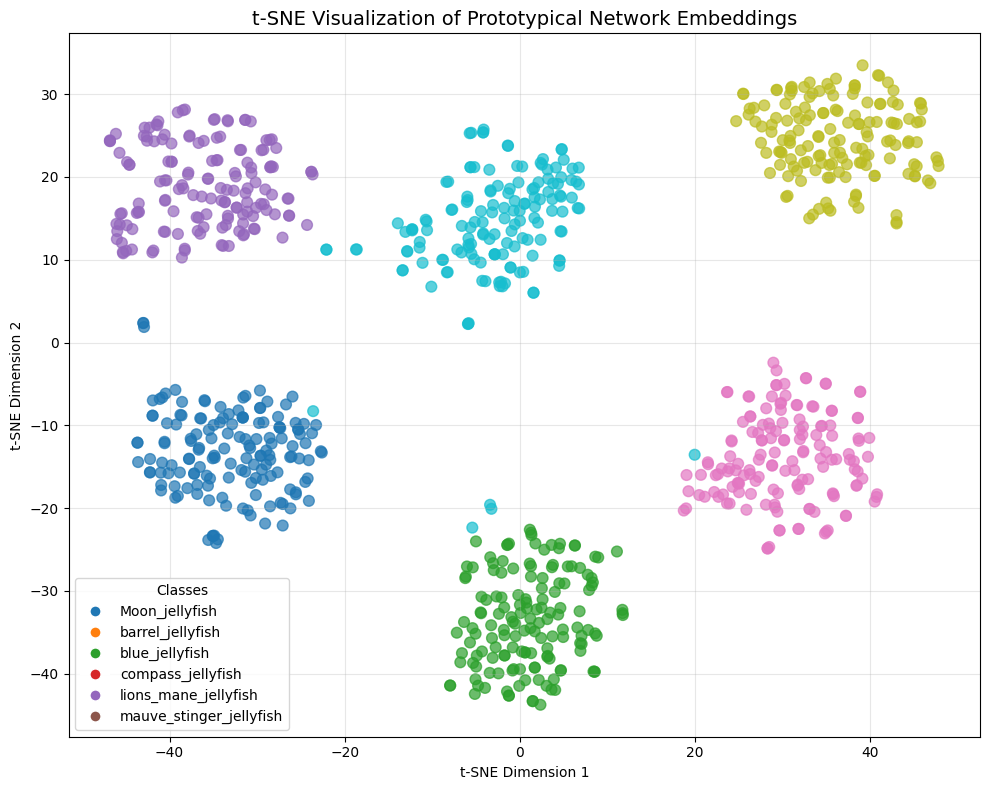

t-SNE visualization complete!


In [14]:
# t-SNE Visualization Cell - Run after training
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import numpy as np
import os # Import os

# Configuration
DATASET_PATH = r"/content/drive/MyDrive/concave"
IMG_SIZE = 64
SUPPORT_SIZE = 5  # Examples per class in support set
QUERY_SIZE = 5    # Examples per class in query set
NUM_WAY = 5       # Number of classes per episode
EPISODES = 200
LEARNING_RATE = 0.001

# Load images
def load_images_from_directory(directory, img_size=IMG_SIZE):
    """Load images grouped by class"""
    data = {}

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue

        images = []
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (img_size, img_size))
                    img = img.astype('float32') / 255.0
                    images.append(img)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

        if images:
            data[class_name] = np.array(images)

    return data
print("Creating t-SNE visualization...")

# Load the data
import cv2 # Import cv2
data = load_images_from_directory(DATASET_PATH)

if not data:
    print("No data loaded. Cannot create t-SNE visualization.")
else:
    # Extract embeddings from the trained model (model is already in memory)
    # Assuming 'model' variable is available from the training cell
    if 'model' not in locals():
        print("Model not found. Please run the training cell first.")
    else:
        embedding_network = model.embedding_net

        # Collect embeddings and labels
        all_embeddings = []
        all_labels = []
        class_names = list(data.keys())

        print("Extracting embeddings from each class...")
        for class_idx, (class_name, images) in enumerate(data.items()):
            # Use fewer samples for faster visualization
            sample_size = min(150, len(images))  # 30 images per class
            sample_indices = np.random.choice(len(images), sample_size, replace=False)
            sample_images = images[sample_indices]

            # Get embeddings
            embeddings = embedding_network.predict(sample_images, verbose=0)
            all_embeddings.append(embeddings)
            all_labels.extend([class_name] * sample_size) # Store class names as labels
            print(f"  {class_name}: {sample_size} samples")

        # Combine all data
        embeddings_matrix = np.vstack(all_embeddings)
        labels_array = np.array(all_labels)

        print(f"Total embeddings shape: {embeddings_matrix.shape}")

        # Normalize embeddings
        scaler = StandardScaler()
        normalized_embeddings = scaler.fit_transform(embeddings_matrix)

        # Apply t-SNE
        print("Running t-SNE...")
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        tsne_result = tsne.fit_transform(normalized_embeddings)

        # Create visualization
        plt.figure(figsize=(10, 8))
        # Using tab10 colormap as it has more distinct colors
        cmap = plt.colormaps.get_cmap('tab10')

        # Get unique class names and create a mapping for coloring
        unique_class_names = np.unique(labels_array)
        color_map = {name: i for i, name in enumerate(unique_class_names)}
        colors = [color_map[label] for label in labels_array]


        scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1],
                           c=colors, cmap=cmap, alpha=0.7, s=60)

        plt.title('t-SNE Visualization of Prototypical Network Embeddings', fontsize=14)
        plt.xlabel('t-SNE Dimension 1')
        plt.ylabel('t-SNE Dimension 2')

        # Create legend with class names
        legend_elements = []
        for class_name in unique_class_names:
             legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', label=class_name,
                                markerfacecolor=cmap(color_map[class_name]), markersize=8))
        plt.legend(handles=legend_elements, title="Classes", loc='best')


        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        print("t-SNE visualization complete!")

Creating t-SNE visualization...
Extracting embeddings from each class...
  Moon_jellyfish: 150 samples
  mauve_stinger_jellyfish: 150 samples
  blue_jellyfish: 150 samples
  lions_mane_jellyfish: 150 samples
  barrel_jellyfish: 150 samples
  compass_jellyfish: 150 samples
Total embeddings shape: (900, 64)
Running t-SNE...


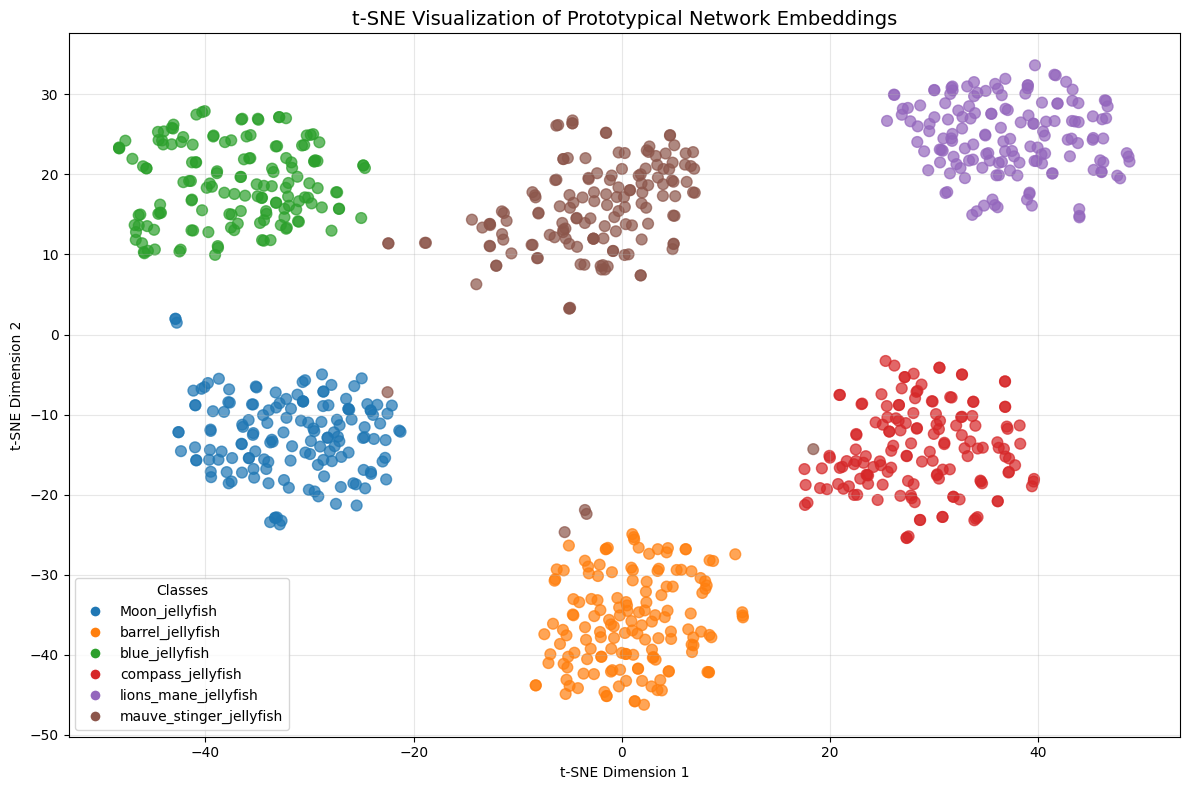

t-SNE visualization complete!


In [15]:
# t-SNE Visualization Cell - Run after training
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import numpy as np
import os
import cv2

# Configuration
DATASET_PATH = r"/content/drive/MyDrive/concave"
IMG_SIZE = 64
SUPPORT_SIZE = 5  # Examples per class in support set
QUERY_SIZE = 5    # Examples per class in query set
NUM_WAY = 5       # Number of classes per episode
EPISODES = 200
LEARNING_RATE = 0.001

# Load images
def load_images_from_directory(directory, img_size=IMG_SIZE):
    """Load images grouped by class"""
    data = {}

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue

        images = []
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (img_size, img_size))
                    img = img.astype('float32') / 255.0
                    images.append(img)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

        if images:
            data[class_name] = np.array(images)

    return data

print("Creating t-SNE visualization...")

# Load the data
data = load_images_from_directory(DATASET_PATH)

if not data:
    print("No data loaded. Cannot create t-SNE visualization.")
else:
    # Extract embeddings from the trained model (model is already in memory)
    if 'model' not in locals():
        print("Model not found. Please run the training cell first.")
    else:
        embedding_network = model.embedding_net

        # Collect embeddings and labels
        all_embeddings = []
        all_labels = []
        class_names = list(data.keys())

        print("Extracting embeddings from each class...")
        for class_idx, (class_name, images) in enumerate(data.items()):
            # Use all images for full dataset visualization
            sample_images = images

            # Get embeddings
            embeddings = embedding_network.predict(sample_images, verbose=0)
            all_embeddings.append(embeddings)
            all_labels.extend([class_name] * len(sample_images))
            print(f"  {class_name}: {len(sample_images)} samples")

        # Combine all data
        embeddings_matrix = np.vstack(all_embeddings)
        labels_array = np.array(all_labels)

        print(f"Total embeddings shape: {embeddings_matrix.shape}")

        # Normalize embeddings
        scaler = StandardScaler()
        normalized_embeddings = scaler.fit_transform(embeddings_matrix)

        # Apply t-SNE
        print("Running t-SNE...")
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        tsne_result = tsne.fit_transform(normalized_embeddings)

        # Create visualization with matching colors
        plt.figure(figsize=(12, 8))

        # Get unique class names and create explicit color mapping
        unique_class_names = np.unique(labels_array)
        cmap = plt.colormaps.get_cmap('tab10')

        # Create explicit color list for consistent coloring
        color_dict = {}
        explicit_colors = []

        for i, class_name in enumerate(unique_class_names):
            color_dict[class_name] = cmap(i)  # Get actual RGBA color

        # Assign colors to each point
        for label in labels_array:
            explicit_colors.append(color_dict[label])

        # Create scatter plot with explicit colors
        scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1],
                            c=explicit_colors, alpha=0.7, s=60)

        plt.title('t-SNE Visualization of Prototypical Network Embeddings', fontsize=14)
        plt.xlabel('t-SNE Dimension 1')
        plt.ylabel('t-SNE Dimension 2')

        # Create legend with matching colors
        legend_elements = []
        for class_name in unique_class_names:
            legend_elements.append(plt.Line2D([0], [0], marker='o', color='w',
                                            label=class_name,
                                            markerfacecolor=color_dict[class_name],
                                            markersize=8))

        plt.legend(handles=legend_elements, title="Classes", loc='best')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        print("t-SNE visualization complete!")
